In [12]:
import os
executable_path = "/home/alberto/.sdkman/candidates/java/current/bin"
if executable_path not in os.environ["PATH"]:
    os.environ["PATH"] = f"{executable_path}:{os.environ['PATH']}"

from scipy.signal import cont2discrete, lti, dstep
import numpy as np
import matplotlib.pyplot as plt

In [13]:
Ra = 5 # Armature resistance [Ohm]
La = 10e-3 # Winding inductance [Henry]
Kb = 0.1 # Motor's back EMF constant 
B = 0.05 # Damping in the motor load
J = 0.01 # Motor inertia [Kg m^2]
Ktau = 5 # Torque constant that relates to the armature current

In [14]:
ss_A = np.array([
    [-Ra/La, 0, -Kb/La],
    [0, 0, 1],
    [Ktau, 0, -B/J]
])
ss_B = np.array([[1/La, 0, 0]]).T
ss_C = np.array([0, 1, 0])
ss_D = 0

dt = 0.1

l_system = lti(ss_A, ss_B, ss_C, ss_D)
d_system = cont2discrete((ss_A, ss_B, ss_C, ss_D), dt, method="zoh")

In [15]:
ss_A, np.linalg.eig(ss_A)

(array([[-500.,    0.,  -10.],
        [   0.,    0.,    1.],
        [   5.,    0.,   -5.]]),
 EigResult(eigenvalues=array([   0.        , -499.89896928,   -5.10103072]), eigenvectors=array([[ 0.00000000e+00, -9.99948968e-01,  1.98248186e-02],
        [ 1.00000000e+00, -2.02091967e-05,  1.92339212e-01],
        [ 0.00000000e+00,  1.01025566e-02, -9.81128230e-01]])))

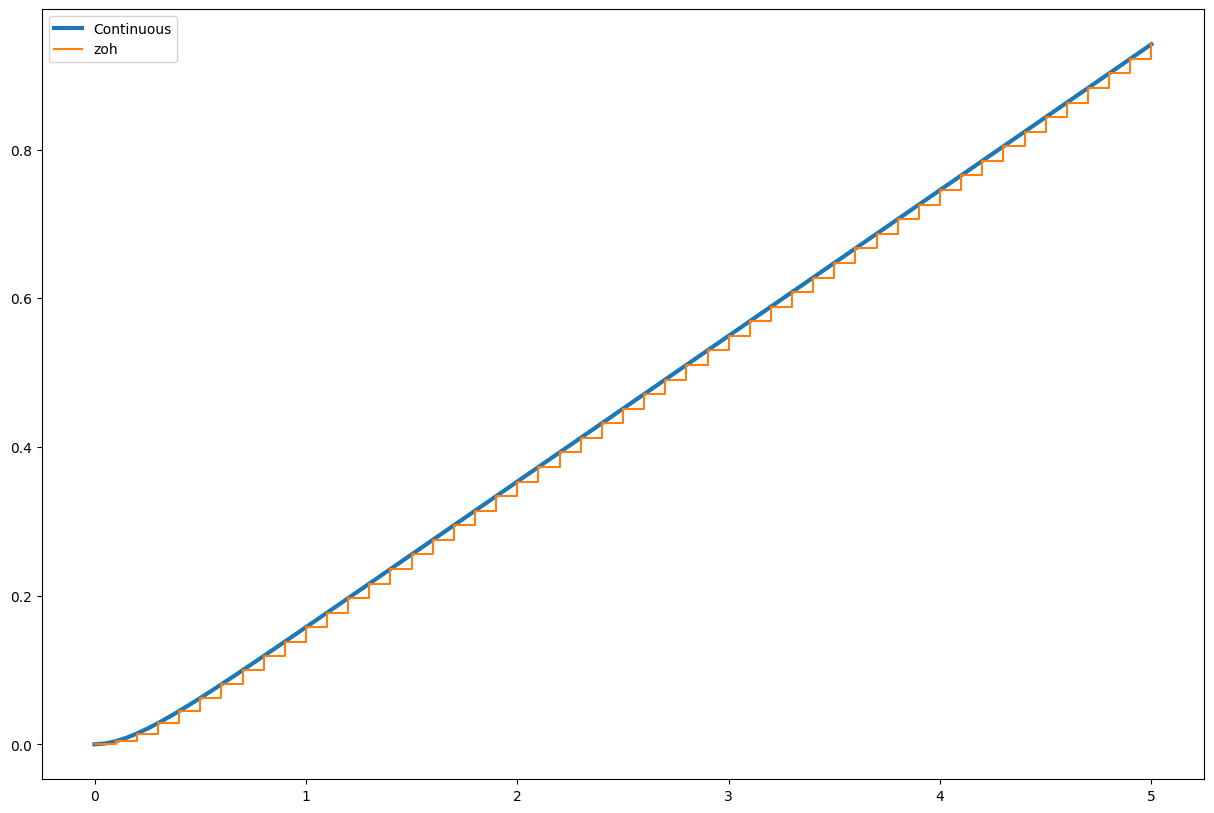

In [16]:
t, x = l_system.step(T=np.linspace(0, 5, 100))

fig, ax = plt.subplots()
ax.plot(t, x, label='Continuous', linewidth=3)


s, x_d = dstep(d_system, t=t)
ax.step(s, np.squeeze(x_d), label="zoh", where='post')

ax.legend(loc='best')
plt.show()

In [17]:
def pid(error, previous_error, parameters):
    Kp, Ki, Kd = parameters

    tension = Kp * error + Ki * (error + previous_error) + Kd * (error - previous_error)

    return tension

In [18]:
X0 = np.array([[0,0,0]]).T
Ys = []

TIME_STEPS = 1000

NO_OVERSHOOT_SLOW = (0.02, 0.03, 0.2)
QUICK_NO_OVERSHOOT = (1, 0.03, 0.2)
RESONANCE = (100, 0.03, 0.2)

for parameters in [NO_OVERSHOOT_SLOW, QUICK_NO_OVERSHOOT, RESONANCE]:
    x = X0
    y = np.array([0])
    u = np.array([0])
    p_err = np.array([0])

    Y = []

    for t in range(TIME_STEPS):
        # Calculate the system output
        y = d_system[2] @ x
        Y.append(y)

        # Compute the error
        error = np.pi - y

        # Use the PID to find the new input
        u = pid(error, p_err, parameters)
        p_err = error

        # Compute the new state
        x = d_system[0] @ x + d_system[1] @ u.reshape(1,1)

    Y = np.array(Y)
    Y = Y.reshape(Y.shape[0])
    Ys.append(Y)

targetSignal = [np.pi for i in range(len(Ys))]
time = np.linspace(0,TIME_STEPS*0.1,num=len(Y))

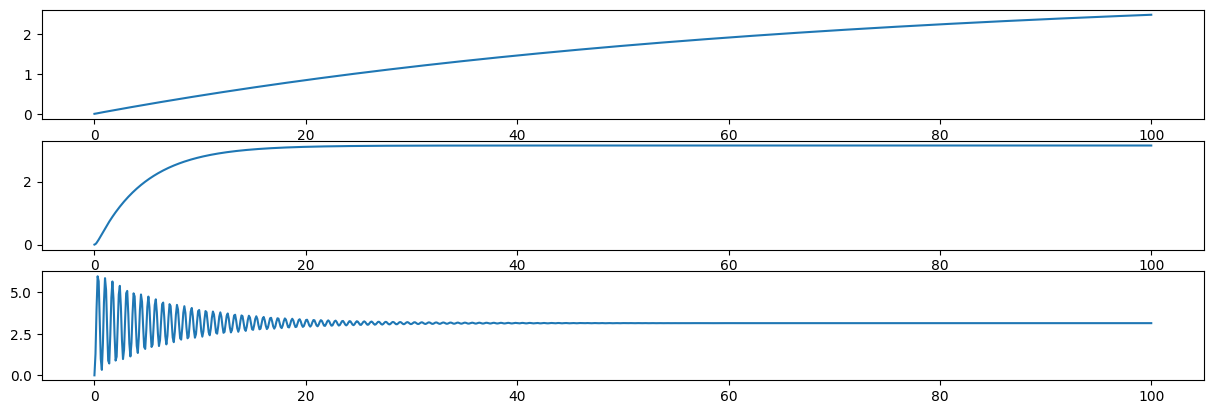

In [19]:
plt.figure(figsize=(15, 15))

for i in range(len(Ys)):
    plt.subplot(9, 1, i+1)
    plt.plot(time, Ys[i])

# Requirements that a controller should satisfy

1. No overshoot
2. Should be quick

In [20]:
import moonlight

In [36]:
script = """
signal { real x; real y; }
domain boolean; 
formula Overshoot = globally [0, 0.1] ( abs(x - y) > 0.1 );
formula Resonance = eventually [0,1] globally[0,90] ((3.1 <= x) & (x <= 3.18));
"""

moonlightScript = moonlight.ScriptLoader.loadFromText(script)

In [42]:
monitors[0].monitor(list(time),signals)

JavaException: JVM exception occurred: Index 3 out of bounds for length 3 java.lang.ArrayIndexOutOfBoundsException

JavaException: JVM exception occurred: Index 3 out of bounds for length 3 java.lang.ArrayIndexOutOfBoundsException

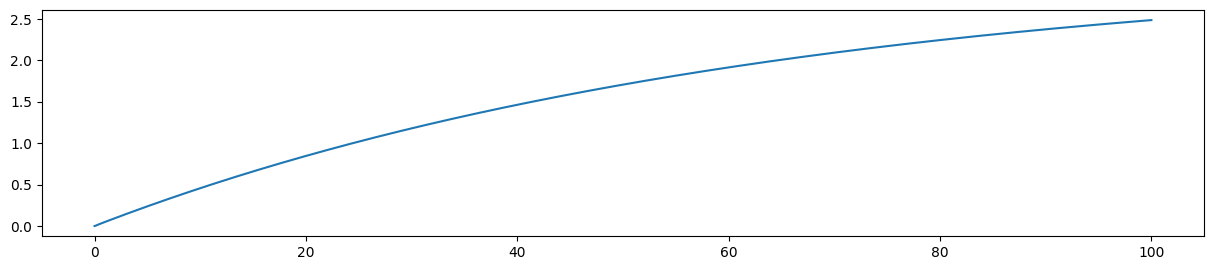

In [37]:
## STEP 4: getting the monitor associated with a target formula

MONITOR_NAMES = ["Overshoot", "Resonance"]

plt.rcParams["figure.figsize"] = (15,10)
for i in range(len(Ys)):
    plt.subplot(3, 1, i+1)

    plt.plot(time,Ys[i], label = '$sin(x)$')

    signals = list(zip(Ys[i], targetSignal))
    monitors = []
    results = []
    for m in MONITOR_NAMES:
        monitor = moonlightScript.getMonitor(m)
        monitors.append(monitor)
        result = np.array(monitor.monitor(list(time),signals))
        results.append(result)

    for i in range(len(results)):
        r = results[i]
        plt.step(r[:,0],r[:,1], where='post', label=MONITOR_NAMES[i])


    plt.title("Plot of Monitor")
    plt.xlabel("Time")
    plt.ylabel("Signal Value")
    plt.legend()
